In [31]:
import glob
import skimage
from skimage import io
from skimage.color import rgb2hsv
from skimage.filters import gabor_kernel
import numpy as np
from numpy import ndarray
import matplotlib.pyplot as plt
import joblib
from scipy import ndimage
import cv2
from scipy.spatial.distance import euclidean
from dataclasses import dataclass
import os
import statistics
from typing import List, Tuple, Dict

In [2]:
# Klasse dient als Ablageort für die Ergebnisse
@dataclass
class DbEntry:
    file_path: str
    category_name: str
    color_histogram: ndarray
    lbp_histogram: ndarray

    def __init__(
            self,
            file_path: str,
            category_name: str,
            color_histogram: ndarray,
            lbp_histogram: ndarray
    ):
        self.file_path = file_path
        self.color_histogram = color_histogram
        self.lbp_histogram = lbp_histogram
        self.category_name = category_name

In [3]:
# erhalten aller Dateinamen inklusive Pfad von
wang_path: str = 'wangCustom10'


def get_file_names(path: str = wang_path):
    # folder_names = []
    file_names = []
    for folder_name in os.listdir(path):
        # folder_names.append(folder_name)
        for file_name in os.listdir(path + "/" + folder_name):
            file_names.append(path + "/" + folder_name + "/" + file_name)
    return file_names

In [27]:
# Aufgabe 1 - generieren des Histograms
def generate_histogram(file_path: str) -> ndarray:
    image = io.imread(file_path)
    hsv_image = rgb2hsv(image)
    hsv_image = hsv_image.reshape(-1, 3)
    hist, edges = np.histogramdd(hsv_image, bins=(5, 3, 3))
    hist = hist.flatten()
    return hist / sum(hist)

In [4]:
# Aufgabe 1 - intersection für den Vergleich berechnen
def calculate_hist_intersection(hist_1: ndarray, hist_2: ndarray) -> float:
    minima = np.minimum(hist_1, hist_2)
    return np.true_divide(np.sum(minima), np.sum(hist_2))

In [5]:
# Aufgabe 1 und 3 - erstellen des Histogramms und LBP
def generate_db_entry_lists():
    file_names = get_file_names()
    file_entries: List[DbEntry] = []
    for file_name in file_names:
        file_entries.append(DbEntry(
            file_name,
            extract_category_from_file_path(file_name),
            generate_histogram(file_name),
            compute_local_binary_pattern(file_name)
        ))
    return file_entries

In [6]:
# persistieren der Ergebnisse
def safe_features_to_file(file_name: str, db_entries: List[DbEntry]):
    joblib.dump(db_entries, file_name)

In [7]:
# laden der persistierten Daten
def load_db_entries(file_name: str = "ftsDB.joblib") -> List[DbEntry]:
    return joblib.load(file_name)

In [28]:
# berechnet die Ähnlichkeit der Bilder und sortiert die Ergebnisse gemäß der Besten
def calc_histogram_similarities(
        image_hist: ndarray,
        db_entries: List[DbEntry] = None
) -> List[Tuple[DbEntry, float]]:
    if db_entries is None:
        db_entries = load_db_entries()

    similarities: List[Tuple[DbEntry, float]] = []

    for db_entry in db_entries:
        similarity = calculate_hist_intersection(db_entry.color_histogram, image_hist)
        similarities.append((db_entry, similarity))

    return sorted(similarities, key=lambda entry: entry[1], reverse=True)

In [9]:
# für das Anzeigen der besten Bilder
def show_images(results: List[Tuple[DbEntry, float]]):
    fig = plt.figure(figsize=(25, 10))
    rows = 2
    columns = 5

    for index, result in enumerate(results):
        image = io.imread(result[0].file_path)
        fig.add_subplot(rows, columns, index + 1)
        plt.imshow(image)
        plt.axis("off")
        plt.title(str(result[1]))

In [10]:
def show_original_image(file_path: str):
    plt.imshow(io.imread(file_path))
    plt.axis("off")
    plt.title("Original Picture")

In [11]:
def extract_category_from_file_path(file_path: str) -> str:
    split_path = file_path.split("/")
    return split_path[len(split_path) - 2]

In [84]:
# Ergebnisse berechnene
db_entries: List[DbEntry] = generate_db_entry_lists()
# Ergebnisse persistieren
safe_features_to_file("ftsDB.joblib", db_entries)

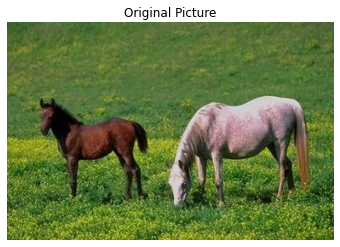

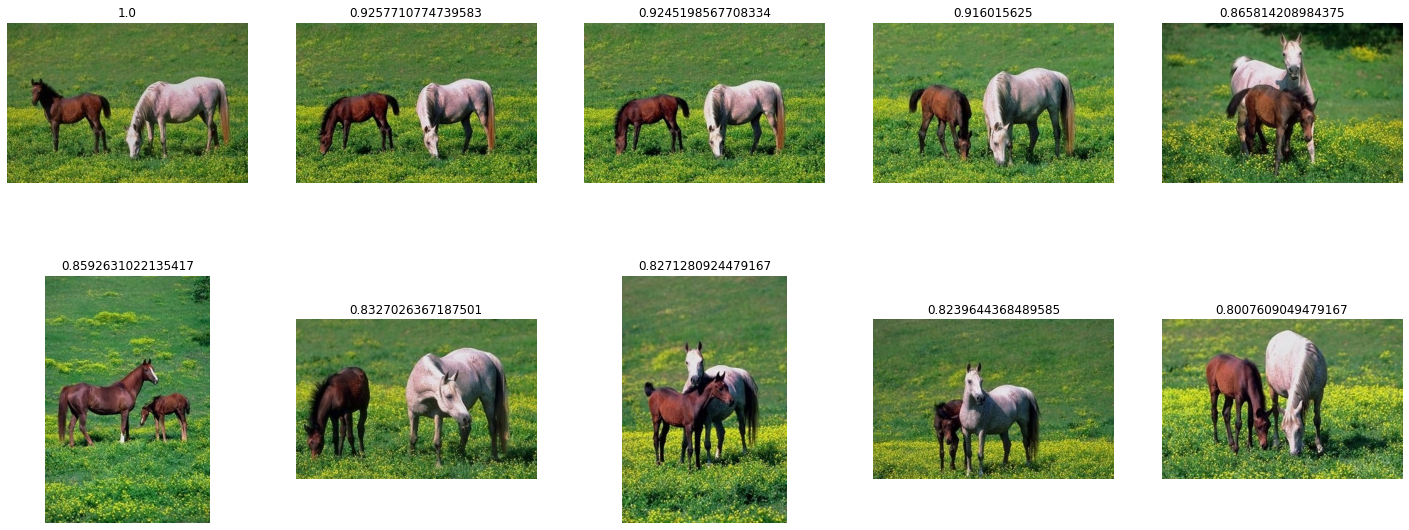

In [45]:
# Aufgabe 1 am Beispiel des Pferds
root_path = os.path.dirname(os.path.abspath("praktikum_4_abgabe.ipynb"))
search_image_path: str = root_path + "/wangCustom10/horses/113060.jpg"

histograms = generate_histogram(file_path=search_image_path)
hist_similarities_result = calc_histogram_similarities(image_hist=histograms)

# Plotting of Results
show_original_image(search_image_path)
show_images(hist_similarities_result[:10])



In [30]:
# START AUFGABE 2

# compute f1 score of result
def compute_f1_score(entry: DbEntry, result_file_paths: List[Tuple[DbEntry, float]]) -> float:
    count: int = 0
    for i in range(len(result_file_paths)):
        if entry.category_name == result_file_paths[i][0].category_name:
            count = count + 1
    precision = count / float(len(result_file_paths))
    rec = count / 100.0  # for each category there are 100 sample images
    f1score = 2 * ((precision * rec) / (precision + rec))
    return f1score

In [32]:
def calculate_category_f1_scores(is_texture_evaluation: bool) -> Dict[str, float]:
    db_entries: List[DbEntry] = load_db_entries()
    category_dict: Dict[str, List[float]] = {}

    for entry in db_entries:
        # histogram: ndarray = generate_histogram(file_path=entry.file_path)
        results: List[Tuple[DbEntry, float]] = compute_local_binary_patterns(
            entry=entry,
            db_entries=db_entries
        )
        if is_texture_evaluation
        else calc_histogram_similarities(
        image_hist=entry.color_histogram,
        db_entries=db_entries
        )

    f1_score: float = compute_f1_score(entry, results[:100])
    category_list = category_dict.get(entry.category_name, [])
    category_list.append(f1_score)
    category_dict[entry.category_name] = category_list


category_dict_result: Dict[str, float] = {}

for category in category_dict.keys():
    category_dict_result[category] = statistics.mean(category_dict[category])

return category_dict_result

In [35]:
def show_f1_score_diagram(category_f1_scores: Dict[str, float]):
    plt.plot(category_f1_scores.values(), marker='o', markerfacecolor='blue', markersize=12)
    plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], category_f1_scores.keys(), rotation='vertical')
    plt.ylim(0, 1)
    plt.grid(visible=True)
    plt.show()

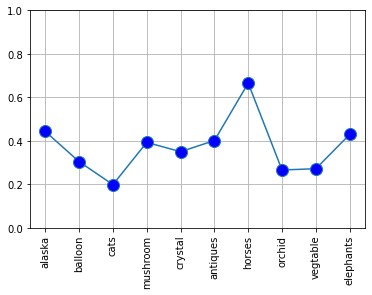

In [36]:
# Execute Aufgabe 2
category_f1_scores = calculate_category_f1_scores(False)
show_f1_score_diagram(category_f1_scores)

In [37]:
# START AUFGABE 3

# berechnet local binary pattern für das Bild
def create_local_binary_pattern(file_path: str) -> ndarray:
    method: str = 'uniform'
    radius: int = 1
    n_points: int = 8 * radius
    image = turn_grey(file_path)
    return skimage.feature.local_binary_pattern(image, P=n_points, R=radius, method=method)

In [38]:
def turn_grey(file_path: str) -> ndarray:
    img = io.imread(file_path)
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

In [39]:
def compute_local_binary_pattern(file_path: str) -> ndarray:
    lbp = create_local_binary_pattern(file_path)
    histogram, _ = np.histogram(lbp, bins=np.arange(2 ** 8 + 1), density=True)
    return histogram

In [40]:
def compute_local_binary_patterns(entry: DbEntry, db_entries: List[DbEntry] = None) -> List[Tuple[DbEntry, float]]:
    if db_entries is None:
        db_entries = load_db_entries()

    euclidean_list: List[Tuple[DbEntry, float]] = []

    for current_entry in db_entries:
        euc: float = euclidean(entry.lbp_histogram, current_entry.lbp_histogram)
        euclidean_list.append((current_entry, euc))

    return sorted(euclidean_list, key=lambda entry: entry[1])

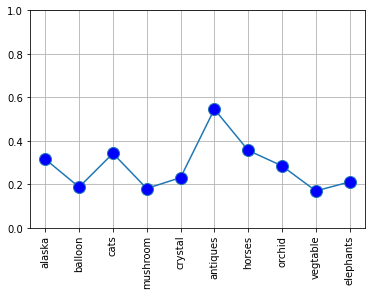

In [41]:
# search_image_path = "D:/Programming/PyCharmProjects/MachineLearning/Praktikum_4/wangCustom10/horses/113060.jpg"
# results_new_new = compute_local_binary_patterns(search_image_path)
# show_original_image(search_image_path)
# show_images(results_new_new[0: 10])

# entries = load_db_entries()
# entry = entries[720]
# results_test = compute_local_binary_patterns(entry=entry, db_entries=entries)
#
# for e in results_test:
#     print(e[0].file_path + ": " + str(e[1]))
#
# print(str(entry))
# show_original_image(entry.file_path)
# show_images(results_test[: 10])


#NEWEST
category_f1_scores = calculate_category_f1_scores(is_texture_evaluation=True)
show_f1_score_diagram(category_f1_scores)

In [42]:
def generate_gabor_kernels():
    kernels = []
    for theta in range(4):
        theta = theta / 4. * np.pi
        for sigma in (1, 3):
            for frequency in (0.05, 0.25):
                kernel = gabor_kernel(frequency=frequency, theta=theta, sigma_x=sigma, sigma_y=sigma)
                kernel_real = np.real(kernel)
                kernels.append(kernel_real)

    return kernels

In [43]:
def compute_gabor_feats(image, kernels):
    feats = np.zeros((len(kernels), 2), dtype=np.double)
    for index, kernel in enumerate(kernels):
        filtered = ndimage.convolve(image, kernel, mode="wrap")
        feats[index, 0] = filtered.mean()
        feats[index, 1] = filtered.var()
    return feats

In [44]:
def match(feats, ref_feats) -> int:
    min_err = np.inf
    min_index: int = 0
    for index in range(ref_feats.shape[0]):
        # Absoluter Fehler, deswegen Squared
        error = np.sum((feats - ref_feats[index, :]) ** 2)
        if error < min_err:
            min_err = error
            min_index = index
    return min_index

In [47]:
from skimage.util import img_as_float

files = get_file_names(root_path + "/wangCustom10/")
shrink = (slice(0, None, 3), slice(0, None, 3))
search_image_path = root_path + "/wangCustom10/horses/113000.jpg"

kernels = generate_gabor_kernels()
ref_feats = np.zeros((len(files), len(kernels), 2), dtype=np.double)
category_labels = []

for index, file in enumerate(files):
    image = io.imread(file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image_float = img_as_float(image)[shrink]
    category_name = extract_category_from_file_path(file)
    category_labels.append(category_name)
    ref_feats[index, :, :] = compute_gabor_feats(image_float, kernels)

image = io.imread(search_image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image_float = img_as_float(image)[shrink]
feats = compute_gabor_feats(image_float, kernels)
category = category_labels[match(feats, ref_feats)]
print(category)

horses


In [48]:
# Checks all entries inside the Dict. Has a reference to the filename in form of the key
def match_new(file_name: str, feats, ref_feats: Dict[str, ndarray]) -> str:
    min_err = np.inf
    category: str = ""
    for key, feat in ref_feats.items():
        if key == file_name:
            continue
        error = np.sum((feats - feat) ** 2)
        if error < min_err:
            min_err = error
            category = extract_category_from_file_path(key)
    return category

In [49]:
def generate_ref_feats(kernels, shrink) -> Dict[str, ndarray]:
    files = get_file_names(root_path + "/wangCustom10/")
    file_ref_feats_dict: Dict[str, ndarray] = {}

    for file in files:
        file_ref_feats_dict[file] = generate_feats(file, kernels, shrink)

    return file_ref_feats_dict

In [50]:
def generate_feats(file_path: str, kernels, shrink) -> ndarray:
    image = io.imread(file_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image_float = img_as_float(image)[shrink]
    return compute_gabor_feats(image_float, kernels)

In [51]:
kernels = generate_gabor_kernels()
shrink = (slice(0, None, 3), slice(0, None, 3))
ref_feats_dict: Dict[str, ndarray] = generate_ref_feats(kernels, shrink)

In [52]:
# Das hab ich gemacht, um durch alle files zu iterieren, und anschleißend für jedes die Kategorie vorherzusagen. Dadurch kann man eine Accuracy der Preditction ableiten.
# Das momentan betrachtete Bild wird dabei ignoriert.
files = get_file_names(root_path + "/wangCustom10/")

results: List[bool] = []

for file_path in files:
    feats = generate_feats(file_path, kernels, shrink)
    predicted_category = match_new(file_path, feats, ref_feats_dict)
    true_category = extract_category_from_file_path(file_path)
    results.append(predicted_category == true_category)

correct_count = len([i for i in results if i])
print("ACCURACY: " + str(float(correct_count) / len(results)))

ACCURACY: 0.2952952952952953


In [53]:
# GLCM Stuff
from skimage.feature import greycoprops, greycomatrix

files = get_file_names(root_path + "/wangCustom10/")

dissimilarities = []
correlations = []
cotrasts = []
energy = []
asm = []

for file in files:
    image = cv2.imread(file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    glcm = greycomatrix(image, distances=[5], angles=[0], levels=256, symmetric=True, normed=True)
    dissimilarities.append(greycoprops(glcm, 'dissimilarity')[0, 0])
    correlations.append(greycoprops(glcm, 'correlation')[0, 0])
    cotrasts.append(greycoprops(glcm, 'contrast')[0, 0])
    energy.append(greycoprops(glcm, 'energy')[0, 0])
    asm.append(greycoprops(glcm, 'ASM')[0, 0])

/Users/john/Files/01_Studium/Machine-Learning-für-Computer-Vision/Praktikum/praktikum04/ML_Praktikum_4/venv/lib/python3.8/site-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/Users/john/Files/01_Studium/Machine-Learning-für-Computer-Vision/Praktikum/praktikum04/ML_Praktikum_4/venv/lib/python3.8/site-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/Users/john/Files/01_Studium/Machine-Learning-für-Computer-Vision/Praktikum/praktikum04/ML_Praktikum_4/venv/lib/python3.8/site-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.